# Implementation: Drawing graphs by eigenvectors

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)  
This work by Yuan-Ching Li is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

## Reference
This work is based on the theory and algorithms provided in [1].

[[1]](https://www.sciencedirect.com/science/article/pii/S089812210500204X) Y. Koren.  Drawing graphs by eigenvectors: theory and practice.  *Computers & Mathematics with Applications*, 49:1867&ndash;1888, 2005.

## Pseudocode
##### Input
- graph $G(V,E)$
    + $V=\{1,2,\dots,n\}$ is the set  of $n$ nodes, 
    + $E=\{ij: 1\leq i,j \leq n, ij\text{ an edge}\}$ is the set of edges, each has weight $w_{ij}$.  
- $p$: the dimension of the layout graph is $p-1$

##### Output
- $u_2, \dots, u_p \in \mathbb{R}^n$ : the first $p-1$ axes of the $(p-1)$-dimensional layout

##### Steps
1. Derive the weighted adjacency matrix $A_{n\times n}$ and compute degrees matrix $D_{n\times n}$ with  
    $A_{ij} = \begin{cases}
     0, & ij \notin E\\
     w_{ij}, & ij \in E
     \end{cases}$ and 
     $D_{ij} = \begin{cases}
     0, & i\neq j\\
     \sum_k A_{ik}, & i=j
     \end{cases}$.  
2. Compute the top nondegenerate eigenvectors $u_2, \dots, u_p$ of $D^{-1}A$ by the following loop :  
    constant $\epsilon \leftarrow 10^{-8}$  
    $u_1 =  \frac{{\bf 1}_n}{\|{\bf 1_n}\|}$  
    **for** $k=2$ to $p$  
    &emsp;&emsp;a random unit vector $\hat{u}_k$  
    &emsp;&emsp;$\hat{u}_k\leftarrow\frac{\hat{u}_k}{\|\hat{u}_k\|}$  
    &emsp;&emsp;**while** $\lVert u_{k}-\hat{u}_{k} \rVert > \epsilon$ **do**  
    &emsp;&emsp;&emsp;&emsp;**for** $j=1$ to $k-1$  
    &emsp;&emsp;&emsp;&emsp;&emsp;$u_{k}\leftarrow \hat{u}_{k}-\frac{\langle Du_j, \hat{u}_{k} \rangle}{\langle Du_j, u_{j} \rangle}u_j$  
    &emsp;&emsp;&emsp;&emsp;**end for**  
    &emsp;&emsp;&emsp;&emsp;$\hat{u}_{k}\leftarrow \frac{1}{2}(I+D^{-1}A)u_{k}$  
    &emsp;&emsp;&emsp;&emsp;$\hat{u}_{k}\leftarrow \frac{\hat{u}_{k}}{\lVert \hat{u}_{k} \rVert}$  
    &emsp;&emsp;**end while**  
    **end for**  
    **return** $u_2,\dots, u_p$
    
##### Note
The norm $\|u\|$ here stands for $u^\top Du$

## Implementation

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)

In [2]:
# 7/13
class spectral_eigv:
    """
    Find the first p-1 axes of the p-dimensional layout.  
    
    First obtain adjancency matrix A and degrees matrix D for weighted graph G.  
    Calculate D-orthogonal eigenvectors by power iteration.  
    
    Input:
       graph G(V,E): V and E are node set and weighted edge set respectively.  
       p: the dimension of the layout graph
       
    Output:
       the first p-1 axes of the p-dimensional layout
    """
    def __init__(self, G, p = 5, eps = 10**(-8)):
        self.G = G
        self.n = G.order()      # number of nodes
        
        self.A = nx.adjacency_matrix(self.G).toarray()    # adjacency matrix
        self.D = np.zeros_like(self.A)    # degrees matrix
        self.D[np.arange(self.n), np.arange(self.n)] = self.A.sum(axis=1)
        
        self.p = p      # number of eigenvectors(including the first eigenvector whose entries are 1)
        self.eps = eps

    def D_quadratic(self, x, y):
        """return xTDy"""
        return np.dot(x, np.dot(self.D, y))
    
    def length(self, x):
        """return root of xTDx"""
        return np.sqrt(self.D_quadratic(x,x))

    def eigenvectors(self, verbose=False):
        self.u = np.ones((self.n,1))
        self.u[:,0] /= self.length(self.u[:,0])
        mul = 0.5 * (np.eye(self.n) + np.dot(np.linalg.inv(self.D), self.A)) # 0.5(I + Dinv A)

        for k in range(2, self.p+1):
            hatv = np.random.randn(self.n)
            hatv /= self.length(hatv)
            
            v = np.zeros_like(hatv)
            while self.length(v-hatv) > self.eps:
                # print(k, "lengths", self.length(v), self.length(hatv), self.length(v-hatv))
                v = hatv
                ### D orthogonalization
                proj = self.u.dot(self.u.T.dot(self.D).dot(v))
                v = v - proj
                # print("dot products:", self.u.T.dot(self.D).dot(v))

                # move from weighted centroid
                hatv = np.dot(mul, v)
                hatv /= self.length(hatv)
            self.u = np.concatenate([self.u, hatv[:,np.newaxis]], axis=1)
            if verbose:
                print(k, 'done')
        self.u = np.delete(self.u, 0, axis=1)
        return self.u

    def show(self):
        V = list(self.G.nodes())
        coordinates = self.u[:,:2]
        pos = {V[i]: coordinates[i] for i in range(self.n)}
        nx.draw_networkx(self.G, 
                         pos=pos, 
                         with_labels=False,
                         node_size=5, 
                         edge_color='#b9bbbd')

## Examples

1. Cycle graph $C_{10}$

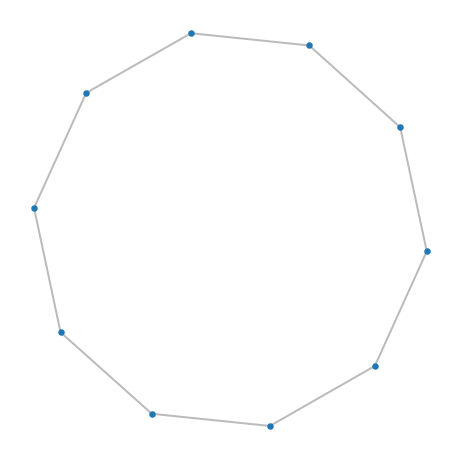

In [3]:
### draw by NetworkX
G = nx.cycle_graph(10)
fig = plt.figure(figsize=(3,3))
nx.draw(G, node_size=5, edge_color='#b9bbbd')

In [4]:
model1 = spectral_eigv(G, p=3, eps=10**-5)
A1, D1 = model1.A, model1.D

# eigenvectors
eig1 = model1.eigenvectors(verbose=True)
eig1

2 done
3 done


array([[ 0.19,  0.25],
       [ 0.01,  0.32],
       [-0.18,  0.26],
       [-0.3 ,  0.1 ],
       [-0.3 , -0.09],
       [-0.19, -0.25],
       [-0.01, -0.32],
       [ 0.18, -0.26],
       [ 0.3 , -0.1 ],
       [ 0.3 ,  0.09]])

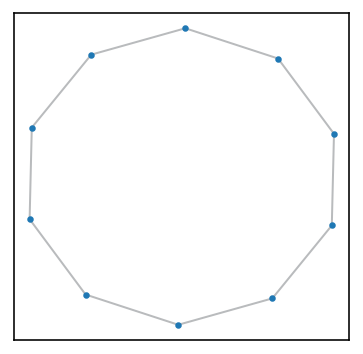

In [5]:
fig = plt.figure(figsize=(3,3))
model1.show()

2. complete bipartite graph $K_{10,3}$

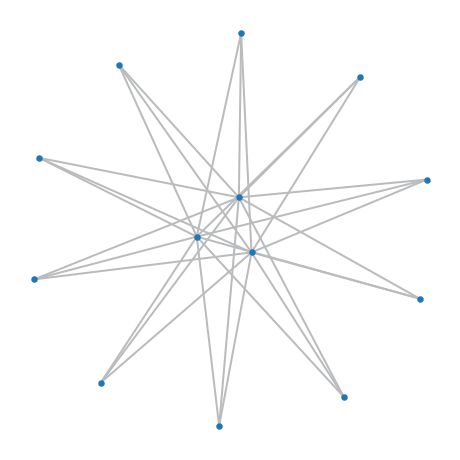

In [6]:
### draw by NetworkX
G = nx.complete_bipartite_graph(10,3)
fig = plt.figure(figsize=(3,3))
nx.draw(G, node_size=5, edge_color='#b9bbbd')

In [7]:
model2 = spectral_eigv(G, p=3, eps=10**-5)
A2, D2 = model2.A, model2.D

# eigenvectors
eig2 = model2.eigenvectors(verbose=True)
eig2

2 done
3 done


array([[ 0.32, -0.18],
       [-0.03,  0.18],
       [-0.15,  0.23],
       [-0.06,  0.03],
       [-0.04,  0.01],
       [-0.05,  0.22],
       [-0.  , -0.18],
       [-0.08, -0.14],
       [-0.  , -0.18],
       [ 0.09,  0.02],
       [-0.05,  0.05],
       [ 0.18,  0.07],
       [-0.14, -0.13]])

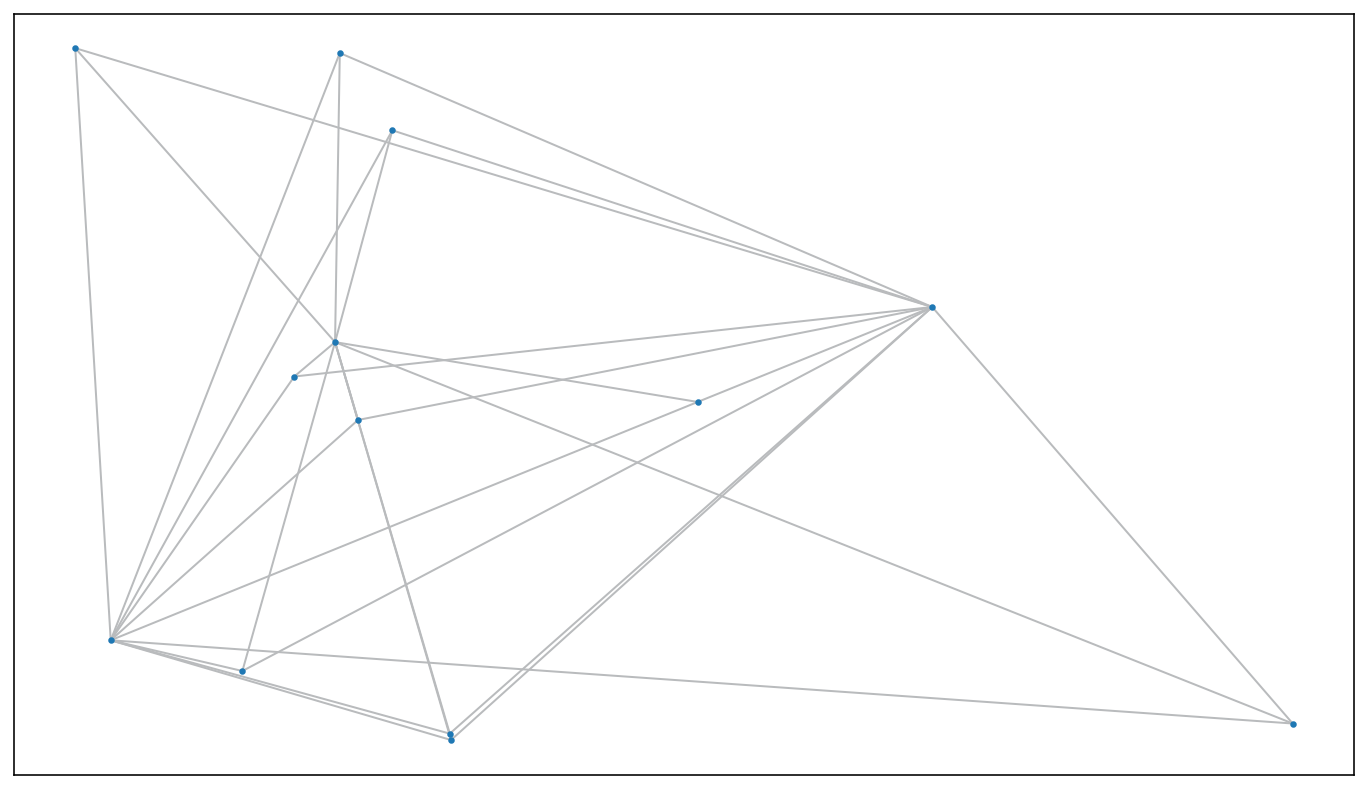

In [8]:
model2.show()

3. Barabasi random graph

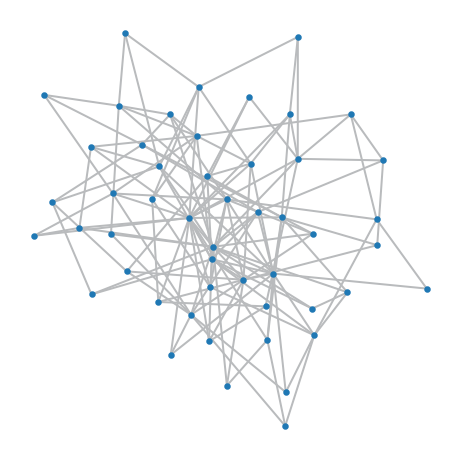

In [9]:
G = nx.barabasi_albert_graph(n=50, m=3, seed=1)
fig = plt.figure(figsize=(3,3))
nx.draw(G, node_size=5, edge_color='#b9bbbd')

In [10]:
# set edge weight
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = float(np.random.rand(1))

In [11]:
model3 = spectral_eigv(G, p=5, eps=10**-5)
A3, D3 = model3.A, model3.D

# eigenvectors
eig3 = model3.eigenvectors(verbose=True)
eig3

2 done
3 done
4 done
5 done


array([[ 2.41e-02, -1.11e-02,  2.41e-02, -1.55e-02],
       [ 4.26e-02, -2.43e-02, -3.37e-03, -5.01e-02],
       [-1.47e-01, -4.57e-02,  6.84e-03,  2.08e-01],
       [-9.38e-02, -6.78e-02, -3.64e-02,  4.67e-02],
       [-2.58e-02, -6.76e-03,  8.58e-03, -6.01e-02],
       [-4.53e-02,  1.52e-02, -6.18e-02, -1.64e-02],
       [ 1.54e-01, -5.17e-02,  1.94e-02, -1.79e-02],
       [-1.06e-02,  5.38e-02, -5.61e-02, -5.37e-02],
       [ 4.59e-02, -8.15e-02,  1.37e-01,  4.71e-02],
       [-4.67e-02,  3.15e-02, -9.15e-02, -4.56e-02],
       [-1.65e-02, -1.51e-02,  1.04e-02, -5.60e-02],
       [-1.06e-01, -1.00e-01, -7.12e-02,  5.40e-02],
       [-4.53e-02, -1.26e-01, -1.66e-02,  4.98e-02],
       [-5.97e-02, -3.33e-02, -5.55e-03, -3.69e-02],
       [-2.46e-02,  7.32e-02,  5.43e-03, -7.16e-02],
       [-4.16e-02,  1.22e-01,  4.52e-02, -6.10e-02],
       [ 1.55e-01,  8.50e-02, -1.54e-01,  1.53e-01],
       [-1.35e-01,  3.83e-02,  8.81e-02,  2.96e-01],
       [ 7.59e-02,  8.65e-02, -6.40e-02,  4.84

In [12]:
# check degree normalized
for i in range(model3.p-2):
    for j in range(i+1,model3.p-1):
        if ((i!=j) and (np.dot(np.dot(eig3[:,i],D3),eig3[:,j]) > model3.eps)):
            print(i,j,'error')
        else:
            print(i,j,'correct')
# check whether eigenvectors are unit vector
for i in range(model3.p-1):
    print(model3.length(eig3[:,i]))

0 1 correct
0 2 correct
0 3 correct
1 2 correct
1 3 correct
2 3 correct
1.0
1.0
1.0
0.9999999999999999


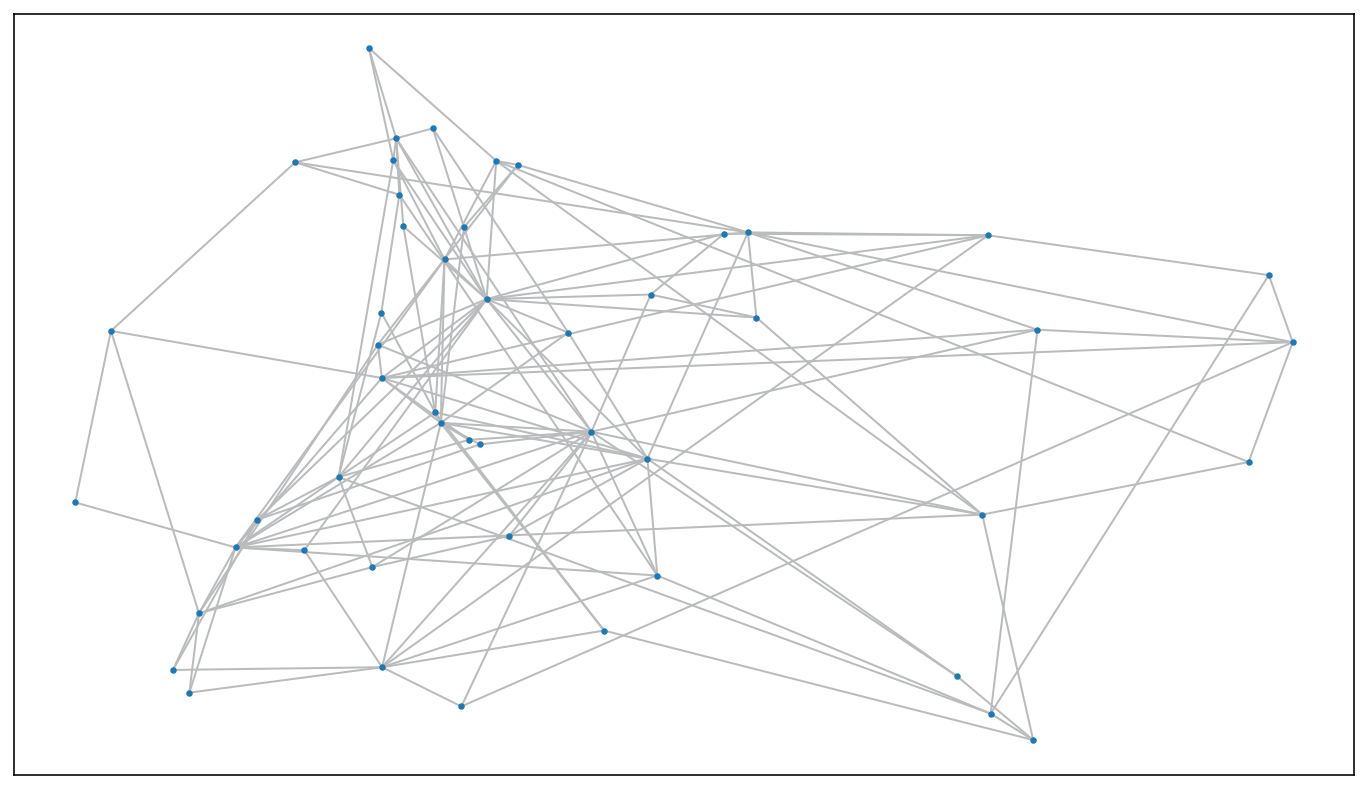

In [13]:
model3.show()

4. football

https://networkx.github.io/documentation/stable/auto_examples/graph/plot_football.html

In [14]:
import io
import zipfile
import urllib.request as urllib

In [15]:
url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"
sock = urllib.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read('football.txt').decode()  # read info file
gml = zf.read('football.gml').decode()
gml = gml.split('\n')[1:]
I = nx.parse_gml(gml)

In [16]:
model4 = spectral_eigv(I, p=5, eps=0.001)
A4, D4 = model4.A, model4.D

# eigenvectors
eig4 = model4.eigenvectors(verbose=True)
eig4

2 done
3 done
4 done
5 done


array([[-1.28e-02,  1.54e-02, -3.23e-02, -4.19e-04],
       [ 3.13e-02,  2.40e-02, -3.66e-02, -4.87e-02],
       [-6.28e-03, -3.51e-02,  3.07e-02,  4.73e-03],
       [-2.16e-02, -4.98e-03,  4.95e-02, -2.37e-02],
       [-3.29e-02,  1.16e-02, -2.51e-02,  1.17e-02],
       [-2.99e-02,  8.01e-03,  4.52e-02, -2.59e-02],
       [-3.40e-04, -3.73e-02,  1.02e-02,  1.25e-02],
       [-4.48e-02, -9.95e-03, -3.61e-02,  1.92e-02],
       [-5.00e-02, -3.02e-03, -5.14e-02,  2.83e-02],
       [-3.73e-02,  2.80e-03, -3.86e-02,  1.96e-02],
       [-2.85e-02, -7.39e-04,  5.64e-02, -3.14e-02],
       [-2.43e-02,  1.50e-02,  1.58e-02, -4.62e-03],
       [ 3.10e-02, -4.05e-02,  1.05e-02,  2.88e-02],
       [ 2.26e-03, -3.24e-02,  1.54e-02,  6.02e-03],
       [ 2.58e-02, -5.55e-02,  1.56e-02,  2.59e-02],
       [-4.05e-03, -3.40e-02,  1.56e-02,  1.39e-02],
       [-2.41e-02,  7.68e-03, -1.59e-02,  1.12e-02],
       [ 2.39e-02,  4.01e-02,  1.01e-02,  4.67e-02],
       [ 3.57e-02, -5.13e-02,  3.48e-03,  1.82

In [17]:
# check degree normalized
for i in range(model4.p-2):
    for j in range(i+1,model4.p-1):
        if ((i!=j) and (np.dot(np.dot(eig4[:,i],D4),eig4[:,j])> model4.eps)):
            print(i,j,'error')
        else:
            print(i,j,'correct')
# check whether eigenvectors are unit vector
for i in range(model4.p-1):
    print(model4.length(eig4[:,i]))

0 1 correct
0 2 correct
0 3 correct
1 2 correct
1 3 correct
2 3 correct
1.0
0.9999999999999999
1.0
1.0


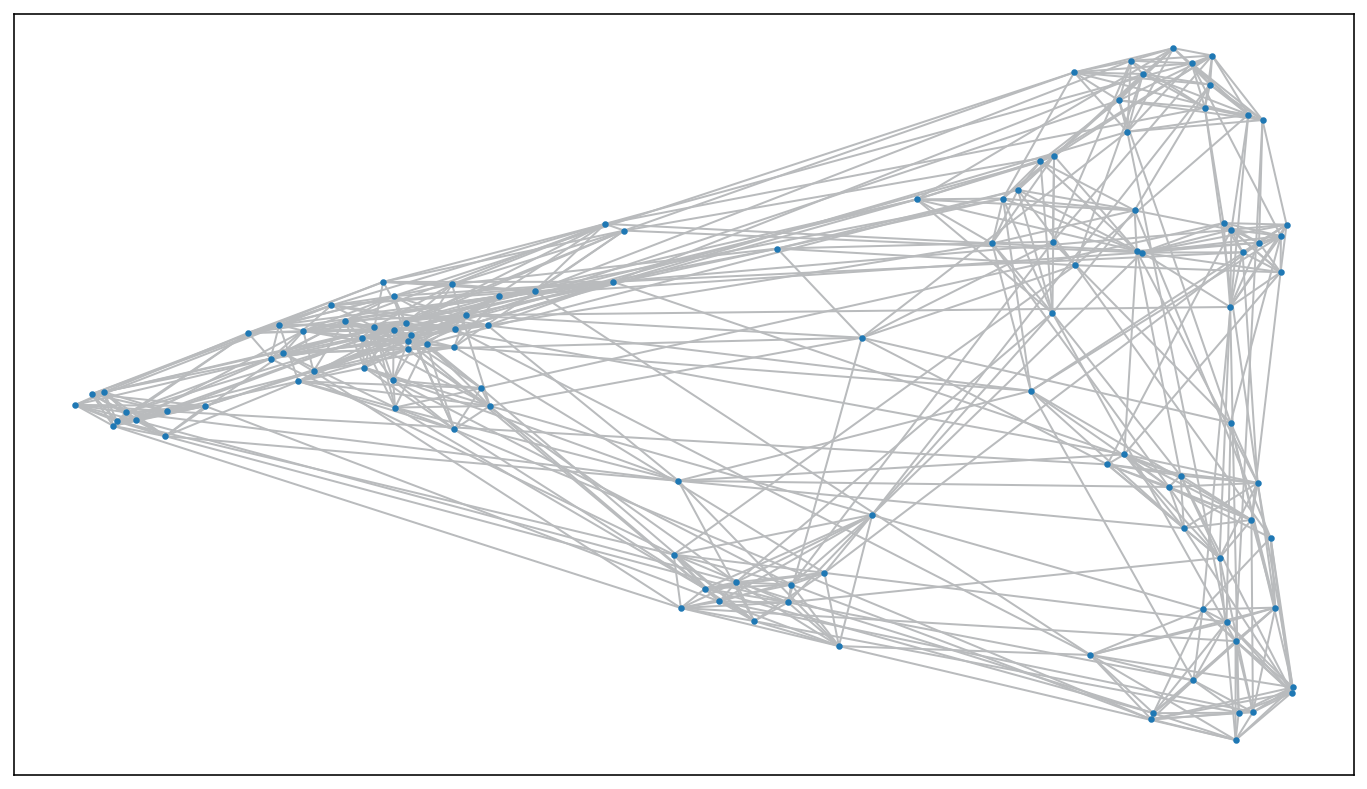

In [18]:
model4.show()

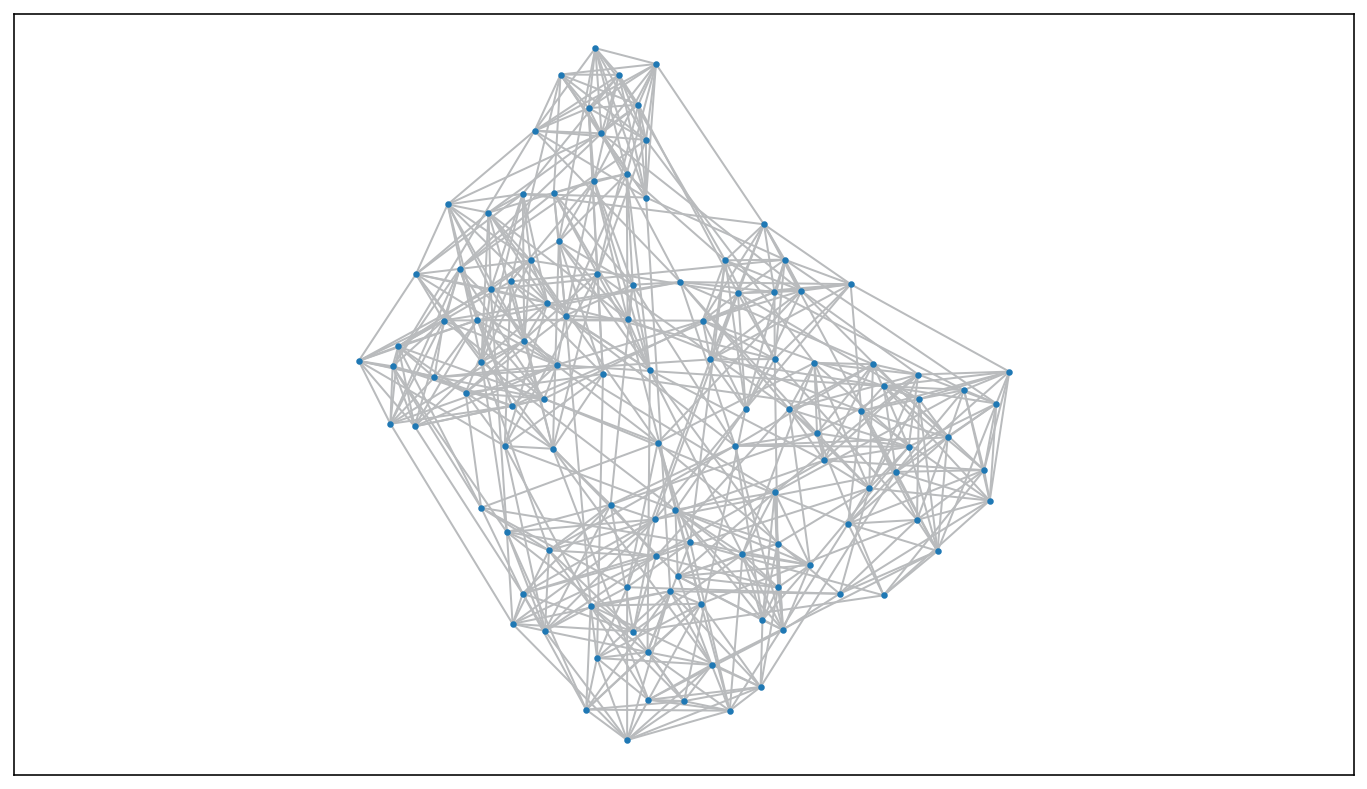

In [19]:
# compare with random drawing
plt.axis('equal')
nx.draw_networkx(I, node_size=5, edge_color='#b9bbbd', with_labels=False)